In [1]:
from htc_numpy import HTC_Numpy
import numpy as np

params = {
    # --- Hilbert space truncations ---
    "dim_cavity": 4,             # truncate cavity to 2 photon levels
    "dim_vib": 2,                # truncate each vibrational mode to 2 levels
    "n_qubits": 2,               # number of qubits
    "n_vib_per_qubit": 1,        # each qubit has 1 vibrational mode

    # --- Uncoupled basis parameters ---
    "cavity_lambda" : 0.01,  #  fundamental cavity coupling strength λ
    "freq_cavity": 0.12086,             # ω_cavity
    "freq_qubit": -7.909490347954424 - -8.030357251614758,   # ω_qubit from S1->S0 at FCI/6-311G** level, r = 1.72 Ang
    "freq_vib_qubit": 0.00622913,          # ω_v (qubit vibrational mode)
    "qubit_huang_rhys": 10.5615447,     # Huang–Rhys factor λ (qubit–vibration coupling)
    "qubit_dipole_values": [-2.354965266795868, -1.0338263686725813, 2.0510843691207983], # [μ_gg, μ_eg, μ_ee] dipole matrix elements for MgH+ at r = 1.65 Ang at CASCI(8,12)/cc-pVDZ level

    # --- Polaritonic basis parameters λ = 0.01, ω_cav = 0.12086 a.u. ---
    "polariton_energies": [-8.030228047173074,  -7.9118897202324305,  -7.9068171192776395,  -7.87191271470145],    # E_pol states
    "polariton_vib_frequencies": [0.006231697, 0.001605895, 0.006938445, 0.001650922],  # vib freq per polariton
    "polariton_huang_rhys": [10.014912366 * 1.0, 0.3183404808 * 1.0, 10.575587891 * 1.0],     # λ per polariton surface
}

# Example: 1 cavity, 2 qubits, 2 vib modes, truncation=2
model = HTC_Numpy(params)


np.set_printoptions(threshold=np.inf)


Characteristic timescales:
T_1 = 309.04091372701396, T_2 = 618.0818274540279
Qubit-cavity coupling strength g = -0.002541405129584934
Total Hilbert space dimension: 64
cavity coupling λ: 0.01
qubit dipole matrix:
[[-0.02354965 -0.01033826]
 [-0.01033826  0.02051084]]
Qubit frequency is 0.12086690366033359, cavity frequency is 0.12086, vib frequency is 0.00622913


In [ ]:
# local operators
# qubits
H_q1 = model.build_local_qubit_hamiltonian()
H_q2 = np.copy(H_q1)

# cavity (only one)
H_c = model.build_local_cavity_hamiltonian()

# field-squared dipole operator for qubits
d = np.copy(model.qubit_d_matrix)

# qubit ladder operators
sp = model.sigma_plus()
sm = model.sigma_minus()

# local boson ladder operators
b_dagger = model.creation(model.dim_cavity)
b = model.annihilation(model.dim_cavity)

# boson number operator
num_op = b_dagger @ b

# local identities
Iq = np.eye(model.dim_qubit)
Ic = np.eye(model.dim_cavity)
Iv = np.eye(model.dim_vib)


# bosonic coupling
bose_coup = b + b_dagger

# JC coupling
HC_1 = model.g_coupling * model._tensor(b, sp, Iq) + model.g_coupling * model._tensor(b_dagger, sm, Iq)
HC_2 = model.g_coupling * model._tensor(b, Iq, sp) + model.g_coupling * model._tensor(b_dagger, Iq, sm)

# Rabi Coupling
Holstein_1 = model.qubit_vib_coupling * model._tensor

At this point, we have the Hamiltonian for qubit 1, cavity, and vibrational mode 1 in the following terms:

`H_PF_composite` -> Hamiltonian for qubit 1 and cavity with coupling between them

`H_q1_c_v1` -> Hamiltonian for the vibrations on qubit1 - cavity and the vibronic coupling

We now need to add qubit 2, the vibrations on qubit 2, and the vibronic coupling of qubit 2.  There is no cavity coupling for qubit 2 for the initial part of the simulation.

In [24]:
# cavity basis states
c0 = np.array([1, 0, 0, 0])
c1 = np.array([0, 1, 0, 0])
c2 = np.array([0, 0, 1, 0])
c3 = np.array([0, 0, 0, 1])
# qubit basis states
g = np.array([1, 0])
e = np.array([0, 1])

# full basis states
zgg = model._tensor(c0, g, g)
zge = model._tensor(c0, g, e)
zeg = model._tensor(c0, e, g)
zee = model._tensor(c0, e, e)
ogg = model._tensor(c1, g, g)
oge = model._tensor(c1, g, e)
oeg = model._tensor(c1, e, g)
oee = model._tensor(c1, e, e)
tgg = model._tensor(c2, g, g)
tge = model._tensor(c2, g, e)
teg = model._tensor(c2, e, g)
tee = model._tensor(c2, e, e)
fgg = model._tensor(c3, g, g)
fge = model._tensor(c3, g, e)
feg = model._tensor(c3, e, g)
fee = model._tensor(c3, e, e)

# create labels for each basis state
basis_labels = {
    0: "|0,g,g>",
    1: "|0,g,e>",
    2: "|0,e,g>",
    3: "|0,e,e>",
    4: "|1,g,g>",
    5: "|1,g,e>",
    6: "|1,e,g>",
    7: "|1,e,e>",
    8: "|2,g,g>",
    9: "|2,g,e>",
    10: "|2,e,g>",
    11: "|2,e,e>",
    12: "|3,g,g>",
    13: "|3,g,e>",
    14: "|3,e,g>",
    15: "|3,e,e>",
}


rho_init = np.outer(zeg, zeg)  # initial state |0,e,g><g,e,0|




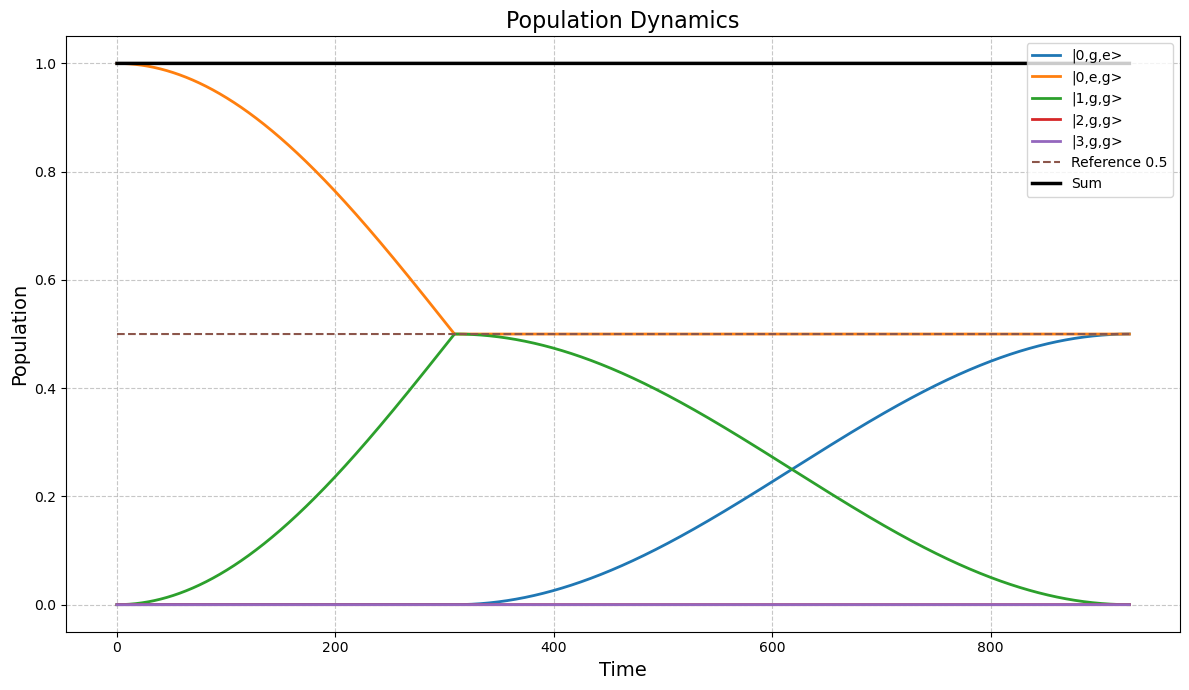

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


dt = 0.01
n_time = int((model.T_1 + model.T_2) / dt)
t = []
populations = {}

# indices of the basis states you care about
basis_indices = [1, 2, 4, 8, 12] # |0,g,e>, |0,e,g>, |1,g,g>
# build dictionary with labels from the model
for idx in basis_indices:
    label = basis_labels[idx]
    populations[label] = []

# add special entries
populations["Reference 0.5"] = []
# we’ll add the “Sum” after the loop

for i in range(n_time):
    t.append(dt * i)

    # evolve
    if dt * i < model.T_1:
        rho_new = model.rk4_step(H_JC_1, rho_init, dt, hbar=1.0)
    else:
        rho_new = model.rk4_step(H_JC_2, rho_init, dt, hbar=1.0)

    norm = np.trace(rho_new)
    #print(f"Norm is {norm:12.10e}")

    rho_init = np.copy(rho_new)

    # record populations for each chosen basis state
    for idx in basis_indices:
        populations[basis_labels[idx]].append(np.real(rho_init[idx, idx]))

    # reference line
    populations["Reference 0.5"].append(0.5)

# add combined population
sum_vals = np.zeros(len(t))
for idx in basis_indices:
    sum_vals += np.array(populations[basis_labels[idx]])
populations["Sum"] = sum_vals

# --- plotting ---
plt.figure(figsize=(12, 7))

for label, values in populations.items():
    if label == "Sum":
        plt.plot(t, values, label=f"{label}", linewidth=2.5, color="black")
    elif label == "Reference 0.5":
        plt.plot(t, values, "--", label=label, linewidth=1.5)
    else:
        plt.plot(t, values, label=label, linewidth=2)

plt.xlabel("Time", fontsize=14)
plt.ylabel("Population", fontsize=14)
plt.title("Population Dynamics", fontsize=16)
plt.legend(fontsize=10, loc="best")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


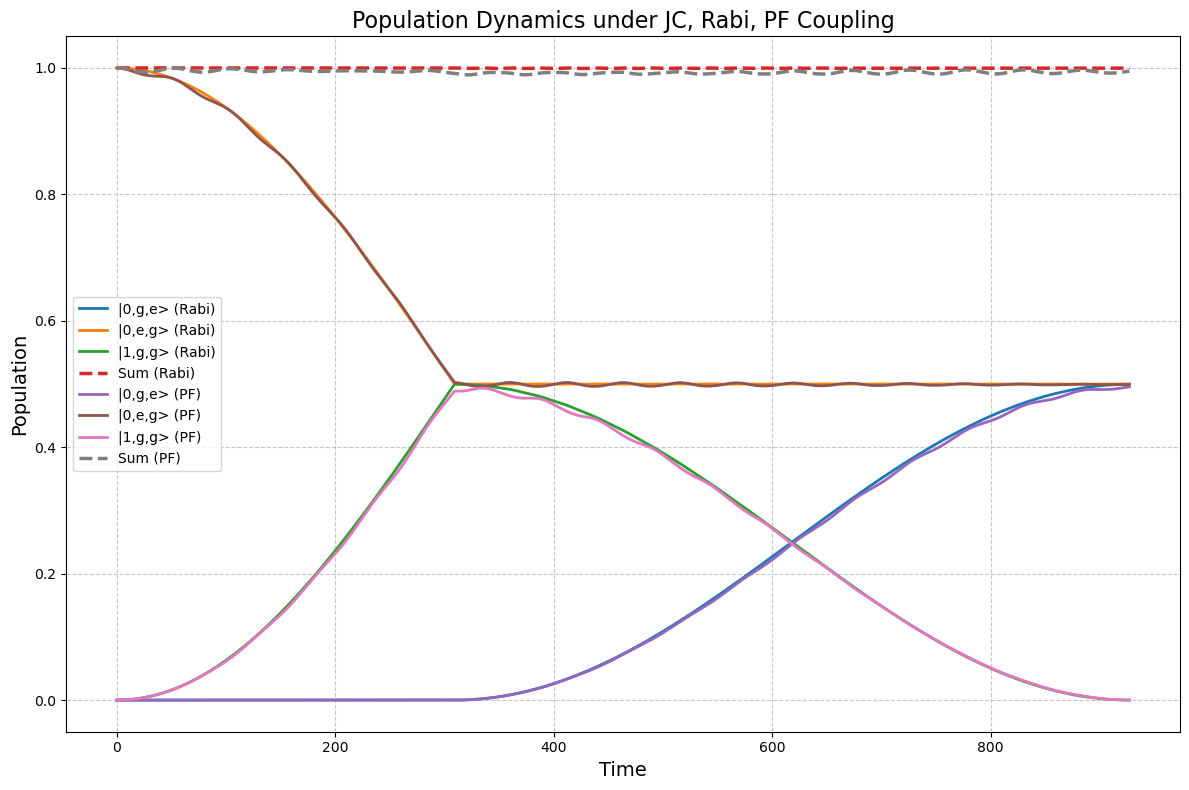

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def run_dynamics(H1, H2, rho_init, basis_indices, basis_labels, model, dt, n_time, label_prefix=""):
    """
    Evolves rho_init under two Hamiltonians (H1 before T1, H2 after T1),
    returns dictionary of selected populations.
    """
    t = []
    populations = {basis_labels[idx]: [] for idx in basis_indices}
    populations["Reference 0.5"] = []

    rho = np.copy(rho_init)

    for i in range(n_time):
        t.append(dt * i)

        # choose Hamiltonian depending on time
        H = H1 if dt * i < model.T_1 else H2
        rho = model.rk4_step(H, rho, dt, hbar=1.0)

        # record populations
        for idx in basis_indices:
            populations[basis_labels[idx]].append(np.real(rho[idx, idx]))

        populations["Reference 0.5"].append(0.5)

    # add combined sum
    sum_vals = np.zeros(len(t))
    for idx in basis_indices:
        sum_vals += np.array(populations[basis_labels[idx]])
    populations["Sum"] = sum_vals

    return t, populations


def plot_comparison(results, basis_indices, basis_labels):
    """
    Plots populations for multiple coupling models on the same figure.
    results: dict of { "Model name": (t, populations_dict) }
    """
    plt.figure(figsize=(12, 8))

    # plot each model separately
    for model_name, (t, pops) in results.items():
        for idx in basis_indices:
            label = f"{basis_labels[idx]} ({model_name})"
            plt.plot(t, pops[basis_labels[idx]], label=label, linewidth=2)

        # plot sum as a dashed line
        plt.plot(t, pops["Sum"], "--", label=f"Sum ({model_name})", linewidth=2.5)

    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Population", fontsize=14)
    plt.title("Population Dynamics under JC, Rabi, PF Coupling", fontsize=16)
    plt.legend(fontsize=10, loc="best")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


# --- run everything ---

dt = 0.01
n_time = int((model.T_1 + model.T_2) / dt)
basis_indices = [1, 2, 4]   # choose subset
rho_init = np.outer(zeg, zeg)      # initial state

results = {}

# JC
#results["JC"] = run_dynamics(H_JC_1, H_JC_2, rho_init, basis_indices, basis_labels, model, dt, n_time)

# Rabi
results["Rabi"] = run_dynamics(H_Rabi_1, H_Rabi_2, rho_init, basis_indices, basis_labels, model, dt, n_time)

# PF
results["PF"] = run_dynamics(H_PF_1, H_PF_2, rho_init, basis_indices, basis_labels, model, dt, n_time)

# Plot comparison
plot_comparison(results, basis_indices, basis_labels)
